In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)


In [206]:
# Same opt for both
opt = {'start_frame':0,
       'num_frames':500,
       'verbose':0,
       'num_subsequent_matches':3,
       'save_candidate_matches':True,
       'add_affine_to_candidates':True}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True
out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_conf, all_frames, candidates = out

  4%|██▉                                                                             | 18/500 [09:14<3:46:37, 28.21s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 97%|████████████████████████████████████████████████████████████████████████████▉  | 487/500 [3:32:45<04:46, 22.06s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|█████████████████████████████████████████████████████████████████████████████  | 488/500 [3:33:07<04:23, 21.95s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 489/500 [3:33:29<04:01, 21.92s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [3:37:30<00:00, 26.10s/it]


## Postprocess 

In [204]:
bp_match_dict = {}
min_edge_weight = 0.5
for key in all_matches:
    these_candidates = [c for c in candidates[key] if c[-1]>min_edge_weight]
    bp_matches = calc_bipartite_matches(these_candidates)
    bp_match_dict[key] = bp_matches
DG_bp = build_digraph_from_matches(bp_match_dict, verbose=0)

Largest connected component size:  9
Sizes and number of components:
[2, 21]
[3, 18]
[4, 45]
[5, 65]
[6, 5]
[7, 2]
[8, 1]
[9, 2]


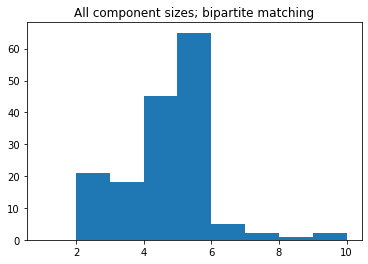

In [205]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp, thresh)
big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

In [161]:
# nx.draw(DG_bp)

In [200]:
tmp = nx.DiGraph()
# tmp.add_weighted_edges_from(candidates[(0,1)])
key = (0,1)
for e in candidates[key]:
    if tmp.has_edge(e[0],e[1]):
        tmp[e[0]][e[1]]['weight'] += e[2]
    else:
        tmp.add_weighted_edges_from([e])

### Just do a smaller network (fewer neurons)


In [130]:
# test_keys = list(all_matches.keys())[:6]
# test_keys = list(all_matches.keys())[:10]
test_keys = [(0,1),(0,2),(1,2)]
print("Only including:")
print(test_keys)

bp_match_dict_small = {}
for key in test_keys:
    bp_matches = calc_bipartite_matches(candidates[key])
    bp_match_dict_small[key] = bp_matches
DG_bp_small = build_digraph_from_matches(bp_match_dict_small, verbose=0)

Only including:
[(0, 1), (0, 2), (1, 2)]


Largest connected component size:  19
Sizes and number of components:
[2, 5]
[3, 104]
[4, 3]
[5, 5]
[6, 1]
[7, 3]
[8, 2]
[11, 1]
[14, 1]
[17, 1]
[19, 1]


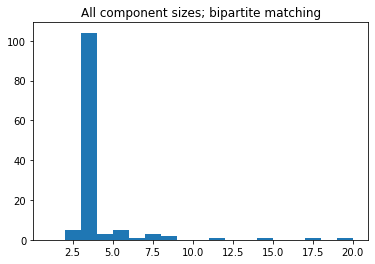

In [131]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp_small, thresh)
big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

In [193]:
k = (0,2)
to_match = 2
f = lambda i : print(f"{to_match} matched with {i}")

[i for i,m in enumerate(bp_match_dict_small[k]) if m[0]==to_match]

[]

## Draw matches with three planes

In [194]:
lines01 = plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (0,1), 
                                            color=[1,0,0],
                                            actually_draw=False)
lines02 = plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (0,2), 
                                            color=[0,1,0],
                                            actually_draw=False)
lines12 = plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (1,2), 
                                            color=[0,0,1],
                                            actually_draw=False)

In [196]:
to_draw = list(lines01)
to_draw.extend(lines02)
to_draw.extend(lines12)
o3d.visualization.draw_geometries(to_draw)

In [49]:
all_frames[7].frame_ind

4

# Attempts to cluster (failed so far)

## Try to cluster these: k_edge_components

Generates nodes in subgraphs that must be k-edge-connected

In [132]:
c = nx.algorithms.connectivity.edge_kcomponents.k_edge_components(DG_bp_small, k=2)
communities = list(c)

## Try to cluster these: label_propagation

Neighbor based. This does not remove any edges or nodes, but is similar to a KNN vote

In [121]:
c = nx.algorithms.community.label_propagation.asyn_lpa_communities(DG_bp)
communities = list(c)

(array([567.,  94.,  41.,  17.,  34.,  24.,  10.,  13.,   5.,   3.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

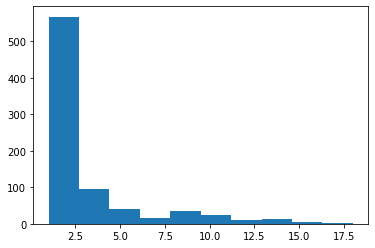

In [122]:
all_len = [len(c) for c in communities]
plt.hist(all_len)

## Try to cluster these: greedy_modularity_communities

Modularity degree based. This does not remove any edges or nodes, but is similar to a KNN vote

In [107]:
c = nx.algorithms.community.greedy_modularity_communities(DG_bp)

IndexError: list index out of range

## Try to cluster these: k-core

Naive degree based. This removes edges if they have few connections

In [102]:
DG_bp_kcore = nx.algorithms.core.k_core(DG_bp, k=4)


In [103]:
len(DG_bp_kcore.nodes())

1276

Largest connected component size:  1276
Sizes and number of components:
[1276, 1]


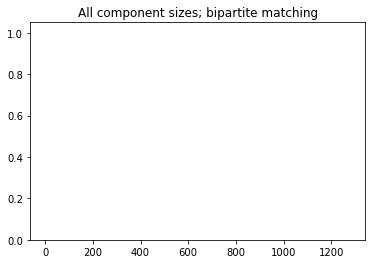

In [104]:
%matplotlib inline

G = DG_bp_kcore

big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

## Try to cluster these: girvan_newman

Betweenness-centrality based. This removes edges if they are bottlenecks, which most of the incorrectly labeled neurons should be

In [133]:
# import itertools
k = 2

all_communities = []
comp = nx.algorithms.community.girvan_newman(DG_bp_small)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))  

([67, 1103, 2134], [56, 1075, 2056], [114, 1112, 2133], [109, 1121, 1139, 2135, 2148], [137, 1148, 2166], [40, 1065, 2052], [16, 125, 127, 1012, 1118, 1169, 2001, 2004, 2118], [128, 1111, 2123], [90, 1108, 2081], [14, 1022, 2011], [105, 116, 145, 1135, 1155, 1159, 1164, 2107, 2126, 2159, 2173], [123, 1132, 2137], [79, 1087, 2069], [117, 1160, 2164], [18, 1034, 2032], [124, 1141, 2163], [99, 1149, 2172], [112, 136, 1154, 1171, 2108, 2138], [75, 1080, 2076], [12, 1014, 2025], [82, 1082, 2073], [126, 1144, 2155], [39, 1060, 2061], [3, 48, 80, 89, 142, 1058, 1098, 1105, 1158, 2046, 2082, 2088, 2121, 2153], [61, 1042, 2054], [122, 1162, 2157], [70, 93, 1072, 1078, 2063, 2071, 2093], [115, 1114, 2136], [46, 1047, 2051], [98, 1094, 2130], [28, 1052, 2044], [32, 1036, 2040], [106, 1097, 2085, 2116], [141, 1150, 2178], [68, 1091, 2079], [102, 1131, 2129], [107, 1130, 2122], [110, 1101, 2152], [119, 1123, 2117], [129, 1138, 2154], [58, 1049, 2042], [5, 1019, 1167, 2008, 2015], [60, 1051, 2043], 

In [ ]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp, thresh)
big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

## Try to cluster these: node2vec

In [77]:
# Cluster based on graph embedding:
# https://stackoverflow.com/questions/62902871/how-can-i-cluster-a-graph-g-created-in-networkx

from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(DG_bp, dimensions=2, walk_length=3, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb") #save the embedding in file embedding.emb

Computing transition probabilities:   0%|          | 0/2312 [00:00<?, ?it/s]

In [80]:
from sklearn.cluster import KMeans

# X = model.wv
X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z

kmeans = KMeans(n_clusters=150, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

[136  22  19 ... 111  96  45]


In [81]:
np.unique(labels, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),
 array([15, 26, 17, 15, 25, 16, 18, 22, 30, 13, 18,  9, 10, 19, 11, 17, 21,
        17, 27, 17, 18, 18, 24, 13, 15, 27,  8, 18,  7, 12, 16,  6, 10, 21,
